In [ ]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
#from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from numpy import expand_dims
#from keras.preprocessing.image import load_img
from keras.utils import load_img
#from keras.preprocessing.image import img_to_array
from keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
#from keras.utils import ImageDataGenerator

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape

import random
from PIL import Image
import scipy.io
from pathlib import Path
import matplotlib.pyplot as plt
import os


!pip3 install kaggle
!kaggle datasets download -d jessicali9530/stanford-cars-dataset
!unzip stanford-cars-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: cars_train/cars_train/03145.jpg  
  inflating: cars_train/cars_train/03146.jpg  
  inflating: cars_train/cars_train/03147.jpg  
  inflating: cars_train/cars_train/03148.jpg  
  inflating: cars_train/cars_train/03149.jpg  
  inflating: cars_train/cars_train/03150.jpg  
  inflating: cars_train/cars_train/03151.jpg  
  inflating: cars_train/cars_train/03152.jpg  
  inflating: cars_train/cars_train/03153.jpg  
  inflating: cars_train/cars_train/03154.jpg  
  inflating: cars_train/cars_train/03155.jpg  
  inflating: cars_train/cars_train/03156.jpg  
  inflating: cars_train/cars_train/03157.jpg  
  inflating: cars_train/cars_train/03158.jpg  
  inflating: cars_train/cars_train/03159.jpg  
  inflating: cars_train/cars_train/03160.jpg  
  inflating: cars_train/cars_train/03161.jpg  
  inflating: cars_train/cars_train/03162.jpg  
  inflating: cars_train/cars_train/03163.jpg  
  inflating: cars_train/cars_train/03164.jpg  
  inflati

In [ ]:
mat = scipy.io.loadmat('cars_annos.mat')
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015', '__version__': '1.0', '__globals__': [], 'annotations': array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        ...,
        (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uin

In [ ]:
annotations_array = mat['annotations'].flatten()
annotations_dict = {
    'relative_im_path': [item[0][0] for item in annotations_array],
    'bbox_x1': [item[1][0][0] for item in annotations_array],
    'bbox_y1': [item[2][0][0] for item in annotations_array],
    'bbox_x2': [item[3][0][0] for item in annotations_array],
    'bbox_y2': [item[4][0][0] for item in annotations_array],
    'class': [item[5][0][0] for item in annotations_array],
    'test': [item[6][0][0] for item in annotations_array]
}
annotations_df = pd.DataFrame(annotations_dict)

annotations_df['relative_im_path'] = annotations_df['relative_im_path'].str.replace('car_ims/', 'cars_train/')

def remove_leading_zero(path):
    parts = path.split('/')
    filename = parts[-1]
    if filename.startswith('0'):
        return '/'.join(parts[:-1] + [filename[1:]])
    else:
        return path

annotations_df['relative_im_path'] = annotations_df['relative_im_path'].apply(remove_leading_zero)

annotations_df.head()


,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test
0,cars_train/00001.jpg,112,7,853,717,1,0
1,cars_train/00002.jpg,48,24,441,202,1,0
2,cars_train/00003.jpg,7,4,277,180,1,0
3,cars_train/00004.jpg,33,50,197,150,1,0
4,cars_train/00005.jpg,5,8,83,58,1,0


In [ ]:
lst = mat.items()
lst = list(lst)
arr = np.array(lst, dtype = object)

In [ ]:
classes = [c for c in arr[4][1][0]]

In [ ]:
print(len(classes))

196


/content
16185


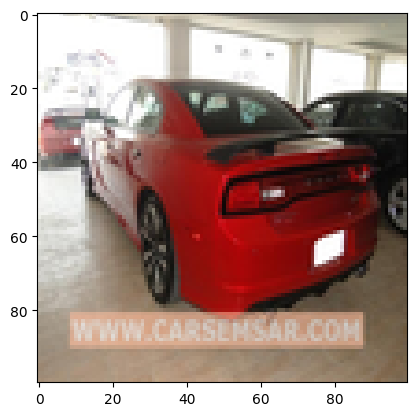

In [ ]:
print(os.getcwd())

print(len(annotations_df))

# Open the image using Pillow
image_path = 'cars_train/' + annotations_df['relative_im_path'][7]  # Replace with the actual image path
img = Image.open(image_path)
resized_img = img.resize((100,100), Image.LANCZOS)

# Display the image using matplotlib
plt.imshow(resized_img)

In [ ]:
# Path to your input image directory
input_dir = 'cars_train/cars_train'

# Target size for resizing
target_size = (128, 128)

# Get a list of all image files in the input directory
# image_files = list(annotations_train['relative_im_path'])
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Initialize an empty numpy array to store the resized images
resized_images = []
final_classes = []

# Iterate over each image file
for image_file in image_files:
    # Load the image using Pillow
    image_path = os.path.join(input_dir, image_file)
    img = Image.open(image_path)

    # Convert grayscale image to RGB by replicating the channel
    # Create a new RGB image and copy grayscale values to all channels
    if len(np.array(img).shape) == 2:
      rgb_img = Image.new('RGB', img.size)
      rgb_img.paste(img, (0, 0, img.width, img.height))
      img = rgb_img

    # Resize the image using interpolation
    resized_img = img.resize(target_size, Image.LANCZOS)

    # Convert the resized image to a numpy array
    resized_array = np.array(resized_img)

    # Append the resized image array to the list
    resized_images.append(resized_array)

    final_classes.append(annotations_df['class'].iloc[annotations_df.index[annotations_df['relative_im_path'] == 'cars_train/' + image_file]].values[0])


print(len(resized_images))


8144


In [ ]:
all_images = np.array(resized_images)
all_images.shape

(8144, 200, 200, 3)

In [ ]:
all_labels = np.array(final_classes)
all_labels.shape

(8144,)

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_images = train_images.astype(np.float32)
train_labels = train_labels.astype(np.float32)
test_images = test_images.astype(np.float32)
test_labels = test_labels.astype(np.float32)

print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)


Train images shape: (6515, 200, 200, 3)
Test images shape: (1629, 200, 200, 3)
Train labels shape: (6515,)
Test labels shape: (1629,)


In [ ]:
pd.Series(train_labels).value_counts()

79.0     77
20.0     74
56.0     74
43.0     74
98.0     74
         ..
45.0     52
2.0      51
64.0     47
99.0     44
100.0    28
Length: 100, dtype: int64

In [ ]:
model = Sequential()
model.add(Reshape((128, 128, 3)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.5))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(.2))
model.add(Dense(196))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_data=(test_images, test_labels))

Epoch 1/10
204/204 [==============================] - ETA: 0s - loss: 39.7660 - accuracy: 0.0087

In [ ]:
from keras.models import load_model

model.save('my_model.h5')